# *__Make March less Mad 2020__*

## Import libraries

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import copy
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
import json
import ast
import time
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

import os
import glob

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

In [0]:
class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)

In [0]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            pass
        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
                         or 'attempt' in col]

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [0]:
class ClassifierModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='auc',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """
        self.cols_to_drop = cols_to_drop

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1 if len(set(y.values)) == 2 else len(set(y.values))
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)
            # y = X['accuracy_group']

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict_proba(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
#             print(classification_report(y, self.oof.argmax(1)))
            print(classification_report(y, (self.oof > 0.5) * 1))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            g = sns.heatmap(confusion_matrix(y, (self.oof > 0.5) * 1), annot=True, cmap=plt.cm.Blues,fmt="d")
            g.set(ylim=(-0.5, 4), xlim=(-0.5, 4), title='Confusion matrix')

            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.xticks(range(self.n_target), range(self.n_target))
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]
            self.cols_to_drop = cols_to_drop
            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)
            if self.cols_to_drop:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict_proba(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        full_evals_results[self.eval_metric] = np.abs(full_evals_results[self.eval_metric])
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

## Import Data from Kaggle

In [5]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robbiemoore","key":"eb58011570ab788e49cbda0546e027c5"}'}

In [6]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir NCAA_data
%cd NCAA_data


/content/NCAA_data


In [7]:
!kaggle competitions download -c google-cloud-ncaa-march-madness-2020-division-1-mens-tournament

  0% 0.00/331k [00:00<?, ?B/s]
100% 331k/331k [00:00<00:00, 49.3MB/s]
  0% 0.00/9.45k [00:00<?, ?B/s]
100% 9.45k/9.45k [00:00<00:00, 9.23MB/s]
  0% 0.00/14.4k [00:00<?, ?B/s]
100% 14.4k/14.4k [00:00<00:00, 14.2MB/s]
  0% 0.00/44.0k [00:00<?, ?B/s]
100% 44.0k/44.0k [00:00<00:00, 43.1MB/s]
  0% 0.00/1.57k [00:00<?, ?B/s]
100% 1.57k/1.57k [00:00<00:00, 1.62MB/s]
  0% 0.00/2.78M [00:00<?, ?B/s]
100% 2.78M/2.78M [00:00<00:00, 91.5MB/s]
  0% 0.00/24.1k [00:00<?, ?B/s]
100% 24.1k/24.1k [00:00<00:00, 23.4MB/s]
  0% 0.00/54.0k [00:00<?, ?B/s]
100% 54.0k/54.0k [00:00<00:00, 54.8MB/s]
  0% 0.00/8.13k [00:00<?, ?B/s]
100% 8.13k/8.13k [00:00<00:00, 8.06MB/s]
 34% 5.00M/14.9M [00:00<00:00, 39.0MB/s]
100% 14.9M/14.9M [00:00<00:00, 72.7MB/s]
  0% 0.00/1.61k [00:00<?, ?B/s]
100% 1.61k/1.61k [00:00<00:00, 1.64MB/s]
  0% 0.00/109k [00:00<?, ?B/s]
100% 109k/109k [00:00<00:00, 97.6MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 161MB/s]
  0% 0.00/370k [00:00<?, ?B/s]
100% 370k/370k [00

## Loading the data

Let's load all useful data into a single dictionary!

In [0]:
data_dict = {}
for i in glob.glob('/content/NCAA_data/*'):
    name = i.split('/')[-1].split('.')[0]
    if name != 'MTeamSpellings':
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='cp1252')

## Data overview

In [0]:
data_dict.keys()

We have a lot of data, but I'll use only some of it in my baseline.

In [0]:
data_dict['MNCAATourneySeeds'].sort_values(by=['Seed'])

Here we can see seeds of all the teams in all seasons.

In [0]:
data_dict['MNCAATourneyCompactResults']

Here we can see pairs of teams which played in tournaments.

In [0]:
data_dict['MNCAATourneyCompactResults'].groupby(['Season'])['WScore'].mean().plot(kind='line');
plt.title('Mean scores of winning teams by season in tourneys');

We can see that mean scores peaked in ~1900 and steadily decreased since that time, but in recent years mean scores rise again. Sadly, I don't know enough info about history of matches in NCAA, but maybe teams prefer to pay more attention to defence now?

In [9]:
def home_conditions(s):
    if s['WLoc'] == 'H':
        return s['WTeamID'], s['WScore'],s['WFGM'], s['WFGA'], s['WFGM3'], s['WFGA3'], s['WFTM'], s['WFTA'], s['WOR'], s['WDR'], s['WAst'], s['WTO'], s['WStl'], s['WBlk'], s['WPF']
    else:
        return s['LTeamID'], s['LScore'], s['LFGM'], s['LFGA'], s['LFGM3'], s['LFGA3'], s['LFTM'], s['LFTA'], s['LOR'], s['LDR'], s['LAst'], s['LTO'], s['LStl'], s['LBlk'], s['LPF']

def away_conditions(s):
    if (s['WLoc'] == 'H'):
        return s['LTeamID'], s['LScore'], s['LFGM'], s['LFGA'], s['LFGM3'], s['LFGA3'], s['LFTM'], s['LFTA'], s['LOR'], s['LDR'], s['LAst'], s['LTO'], s['LStl'], s['LBlk'], s['LPF']
    else:
        return s['WTeamID'], s['WScore'], s['WFGM'], s['WFGA'], s['WFGM3'], s['WFGA3'], s['WFTM'], s['WFTA'], s['WOR'], s['WDR'], s['WAst'], s['WTO'], s['WStl'], s['WBlk'], s['WPF']

def efg(s):
    return ((s['HFGM']+0.5*s['HFGM3'])/s['HFGA']), ((s['AFGM']+0.5*s['AFGM3'])/s['AFGA'])

def tovp(s):
    return (s['HTO']/(s['HFGA'] + 0.44*s['HFTA'] + s['HTO'])), (s['ATO']/(s['AFGA'] + 0.44*s['AFTA'] + s['ATO']))

def orbp(s):
    return (s['HOR']/(s['HOR'] + s['ADR'])), (s['AOR']/(s['AOR'] + s['HDR']))

def ftr(s):
    return (s['HFTM']/s['HFGA']), (s['AFTM']/s['AFGA'])

rs_df = data_dict['MRegularSeasonDetailedResults'].copy()
rs_df = rs_df.drop(['NumOT'], axis=1)
rs_df = rs_df.loc[rs_df['Season'] >= 2010]

rs_df['HomeTeamID'], rs_df['HScore'], rs_df['HFGM'], rs_df['HFGA'], rs_df['HFGM3'], rs_df['HFGA3'], rs_df['HFTM'], rs_df['HFTA'], rs_df['HOR'], rs_df['HDR'], rs_df['HAST'], rs_df['HTO'], rs_df['HStl'], rs_df['HBlk'], rs_df['HPF'] = zip(*rs_df.apply(home_conditions, axis=1))
rs_df['AwayTeamID'], rs_df['AScore'], rs_df['AFGM'], rs_df['AFGA'], rs_df['AFGM3'], rs_df['AFGA3'], rs_df['AFTM'], rs_df['AFTA'], rs_df['AOR'], rs_df['ADR'], rs_df['AAST'], rs_df['ATO'], rs_df['AStl'], rs_df['ABlk'], rs_df['APF'] = zip(*rs_df.apply(away_conditions, axis=1))
rs_df['Home_eFG'], rs_df['Away_eFG'] = zip(*rs_df.apply(efg, axis=1))
rs_df['Home_TOVP'], rs_df['Away_TOVP'] = zip(*rs_df.apply(tovp, axis=1))
rs_df['Home_ORBP'], rs_df['Away_ORBP'] = zip(*rs_df.apply(orbp, axis=1))
rs_df['Home_FTR'], rs_df['Away_FTR'] = zip(*rs_df.apply(ftr, axis=1))

rs_df = rs_df.drop(['WTeamID', 'WScore', 'LTeamID', 'LScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3','LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1)
rs_df["WLoc"] = rs_df['WLoc'].map({"N": "A", "H": "H"})
rs_df.rename(columns={"WLoc": "Winner"})



,Season,DayNum,Winner,HomeTeamID,HScore,HFGM,HFGA,HFGM3,HFGA3,HFTM,HFTA,HOR,HDR,HAST,HTO,HStl,HBlk,HPF,AwayTeamID,AScore,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAST,ATO,AStl,ABlk,APF,Home_eFG,Away_eFG,Home_TOVP,Away_TOVP,Home_ORBP,Away_ORBP,Home_FTR,Away_FTR
34074,2010,7,H,1143,75,24,52,5,12,22,32,13,19,15,12,8,1,14,1293,70,26,52,8,21,10,15,11,20,11,17,7,3,24,0.509615,0.576923,0.153689,0.224868,0.393939,0.366667,0.423077,0.192308
34075,2010,7,H,1314,88,34,61,4,13,16,19,12,32,23,26,10,8,19,1198,72,25,68,8,23,14,17,13,16,15,20,14,2,18,0.590164,0.426471,0.272651,0.209468,0.428571,0.288889,0.262295,0.205882
34076,2010,7,H,1326,100,39,73,14,33,8,12,13,34,29,6,8,6,19,1108,60,21,61,7,17,11,20,11,24,7,13,4,5,16,0.630137,0.401639,0.071191,0.157005,0.351351,0.244444,0.109589,0.180328
34077,2010,7,H,1393,75,29,60,2,17,15,31,14,32,21,21,21,6,16,1107,43,15,55,5,28,8,14,12,27,10,32,12,4,27,0.500000,0.318182,0.221893,0.343495,0.341463,0.272727,0.250000,0.145455
34078,2010,9,H,1143,95,29,61,7,17,30,35,15,30,11,10,5,3,20,1178,61,20,57,4,18,17,27,14,18,14,15,4,2,21,0.532787,0.385965,0.115741,0.178827,0.454545,0.318182,0.491803,0.298246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,132,A,1222,57,19,62,8,33,11,18,17,16,8,7,2,4,19,1153,69,22,50,6,17,19,25,12,27,6,11,2,3,16,0.370968,0.500000,0.091004,0.152778,0.386364,0.428571,0.177419,0.380000
87500,2019,132,A,1426,64,23,64,7,33,11,17,13,28,12,14,5,2,24,1209,73,20,50,8,22,25,34,5,31,8,10,4,5,18,0.414062,0.480000,0.163781,0.133404,0.295455,0.151515,0.171875,0.500000
87501,2019,132,A,1276,60,21,51,8,25,10,12,3,26,17,6,5,5,11,1277,65,22,55,9,23,12,16,11,27,14,9,2,6,10,0.490196,0.481818,0.096339,0.126689,0.100000,0.297297,0.196078,0.218182
87502,2019,132,A,1382,53,19,56,7,19,8,10,13,30,9,11,2,7,16,1387,55,22,59,4,22,7,15,15,25,13,6,6,8,11,0.401786,0.406780,0.154062,0.083799,0.342105,0.333333,0.142857,0.118644


In [10]:
rs_df.head()

,Season,DayNum,WLoc,HomeTeamID,HScore,HFGM,HFGA,HFGM3,HFGA3,HFTM,HFTA,HOR,HDR,HAST,HTO,HStl,HBlk,HPF,AwayTeamID,AScore,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAST,ATO,AStl,ABlk,APF,Home_eFG,Away_eFG,Home_TOVP,Away_TOVP,Home_ORBP,Away_ORBP,Home_FTR,Away_FTR
34074,2010,7,H,1143,75,24,52,5,12,22,32,13,19,15,12,8,1,14,1293,70,26,52,8,21,10,15,11,20,11,17,7,3,24,0.509615,0.576923,0.153689,0.224868,0.393939,0.366667,0.423077,0.192308
34075,2010,7,H,1314,88,34,61,4,13,16,19,12,32,23,26,10,8,19,1198,72,25,68,8,23,14,17,13,16,15,20,14,2,18,0.590164,0.426471,0.272651,0.209468,0.428571,0.288889,0.262295,0.205882
34076,2010,7,H,1326,100,39,73,14,33,8,12,13,34,29,6,8,6,19,1108,60,21,61,7,17,11,20,11,24,7,13,4,5,16,0.630137,0.401639,0.071191,0.157005,0.351351,0.244444,0.109589,0.180328
34077,2010,7,H,1393,75,29,60,2,17,15,31,14,32,21,21,21,6,16,1107,43,15,55,5,28,8,14,12,27,10,32,12,4,27,0.500000,0.318182,0.221893,0.343495,0.341463,0.272727,0.250000,0.145455
34078,2010,9,H,1143,95,29,61,7,17,30,35,15,30,11,10,5,3,20,1178,61,20,57,4,18,17,27,14,18,14,15,4,2,21,0.532787,0.385965,0.115741,0.178827,0.454545,0.318182,0.491803,0.298246


In [11]:
import networkx as nx
pagerank_df = np.zeros((1466 - 1100,1466 - 1100))
for ind in rs_df.index: 
  if rs_df['WLoc'][ind] == 'H':
    pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 5
  else:
    pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 5
  if rs_df['Home_eFG'][ind] > rs_df['Away_eFG'][ind]:
    pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 4
  elif rs_df['Home_eFG'][ind] < rs_df['Away_eFG'][ind]:
    pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 4
  if rs_df['Home_TOVP'][ind] < rs_df['Away_TOVP'][ind]:
    pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 2.5
  elif rs_df['Home_TOVP'][ind] > rs_df['Away_TOVP'][ind]:
    pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 2.5
  if rs_df['Home_ORBP'][ind] > rs_df['Away_ORBP'][ind] :
    pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 2
  elif rs_df['Home_ORBP'][ind] < rs_df['Away_ORBP'][ind]:
    pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 2
  if rs_df['Home_FTR'][ind] > rs_df['Away_FTR'][ind]:
    pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 1.5
  elif rs_df['Home_FTR'][ind] < rs_df['Away_FTR'][ind]:
    pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 1.5

def sortSecond(val): 
    return val[1] 

G = nx.DiGraph(pagerank_df)
pr = nx.pagerank(G, alpha = 0.85)
ranking = []
for i in pr : 
    ranking.append((i + 1101, pr[i]))
ranking.sort(key = sortSecond, reverse=True)
print(ranking)

[(1181, 0.0070984289359688766), (1314, 0.00679434853487593), (1242, 0.006677310522932888), (1246, 0.006490734941205548), (1438, 0.006180983898510022), (1277, 0.006171893279158301), (1458, 0.0057402003001466445), (1257, 0.005701461861332651), (1437, 0.005616802186945065), (1393, 0.005613460882712394), (1196, 0.00560935315191874), (1326, 0.005586462185052988), (1345, 0.005444765124265509), (1276, 0.0054231557362008215), (1112, 0.0053464542422658155), (1199, 0.0052534783641998645), (1124, 0.005181714109614083), (1211, 0.005134369135572482), (1400, 0.005121198364270644), (1153, 0.0051166452541728065), (1452, 0.005111142258073301), (1274, 0.005094812928391832), (1323, 0.005093538055964305), (1243, 0.0050446822236870645), (1235, 0.005044069705119384), (1397, 0.004986242613880655), (1268, 0.004934198506077732), (1462, 0.004893353095503584), (1301, 0.004821207853893757), (1266, 0.00467661395882343), (1231, 0.004666678689395302), (1417, 0.004645198565964542), (1155, 0.004621655457952896), (1329

In [12]:
!pip install scprep

     |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
import umap
import scprep
import matplotlib.pyplot as plt

In [0]:
mapper = umap.UMAP(n_neighbors=20)
data_umap = mapper.fit_transform(pagerank_df)

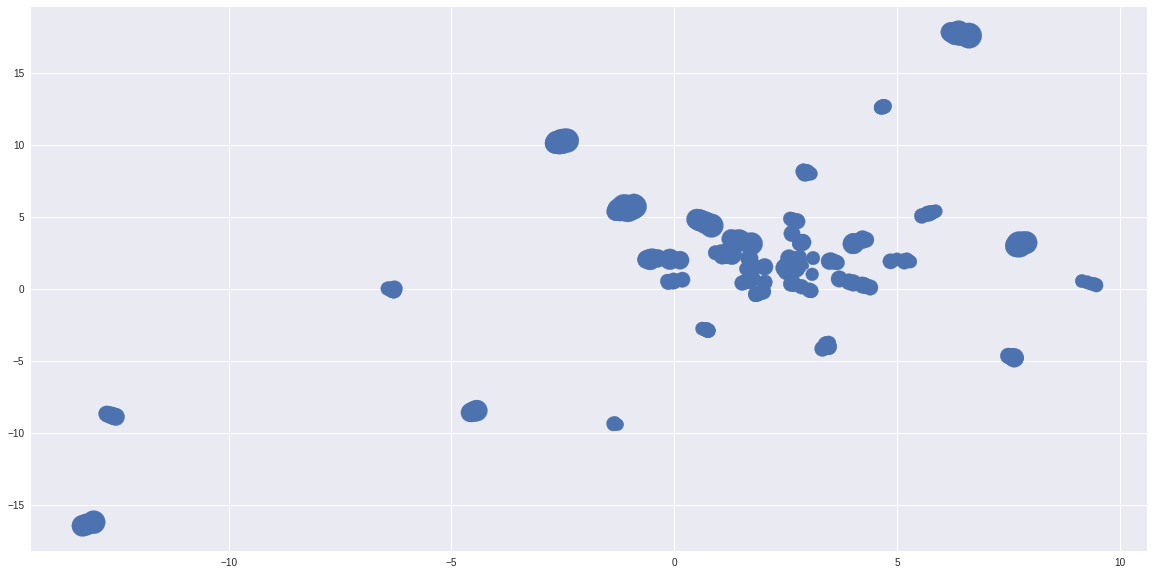

In [71]:
plt.figure(figsize=(20,10))
plt.scatter(*data_umap.T , [x*100000 for x in pr.values()])

In [0]:
from sklearn.manifold import TSNE
pr_embedded = TSNE(n_components=2).fit_transform(pagerank_df)


In [0]:
conference = data_dict['MTeamConferences'].loc[data_dict['MTeamConferences']['Season'] == 2020].drop(['Season'], axis=1)

In [110]:
conference.shape

(353, 2)

In [0]:
conference_list = conference['ConfAbbrev'].to_list()

In [106]:
len(conference_list)

353

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
target =le.fit_transform(conference_list)

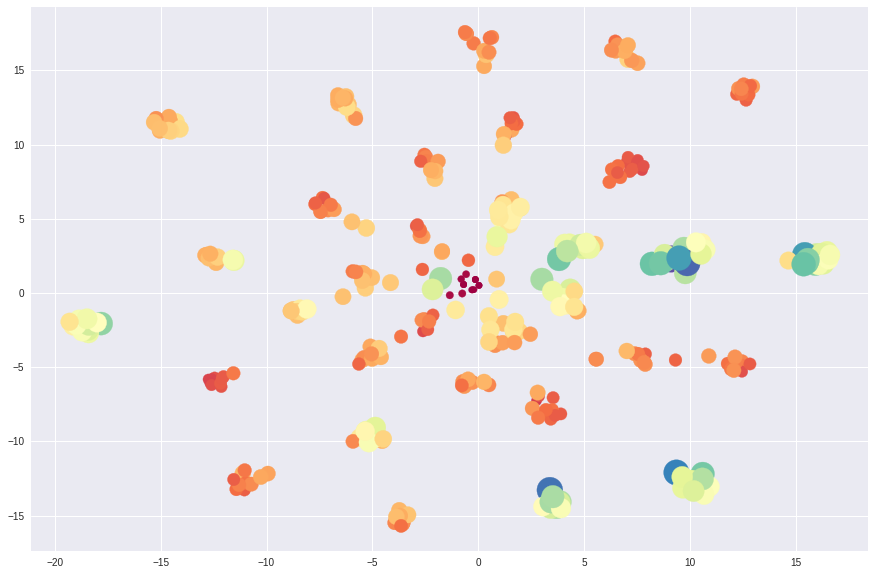

In [113]:
plt.figure(figsize=(15,10))
plt.scatter(*pr_embedded.T , [x*100000 for x in pr.values()], c=[x*100000 for x in pr.values()], cmap='Spectral')

In [0]:
data_dict['MRegularSeasonCompactResults']

And here we can see the results of regular seasons.

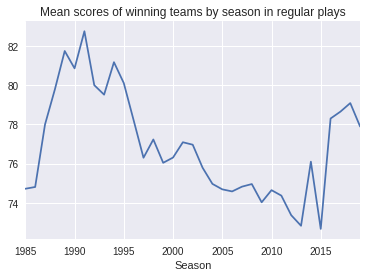

In [0]:
data_dict['MRegularSeasonCompactResults'].groupby(['Season'])['WScore'].mean().plot();
plt.title('Mean scores of winning teams by season in regular plays');

## Data processing and feature engineering.

The main idea is to extract features, which could be useful to understand how much one team is better than another one.

In [0]:
# process seed
data_dict['MNCAATourneySeeds']['Seed'] = data_dict['MNCAATourneySeeds']['Seed'].apply(lambda x: int(x[1:3]))
# take only useful columns
data_dict['MNCAATourneySeeds'] = data_dict['MNCAATourneySeeds'][['Season', 'TeamID', 'Seed']]
data_dict['MNCAATourneyCompactResults'] = data_dict['MNCAATourneyCompactResults'][['Season','WTeamID', 'LTeamID']]

# merge the data and rename the columns
df = pd.merge(data_dict['MNCAATourneyCompactResults'], data_dict['MNCAATourneySeeds'],
              how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df = pd.merge(df, data_dict['MNCAATourneySeeds'], how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df = df.drop(['TeamID_x', 'TeamID_y'], axis=1)
df.columns = ['Season', 'WTeamID', 'LTeamID', 'WSeed', 'LSeed']
df.head()

TypeError: ignored

In [0]:
df.head()

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,9,8
1,1985,1120,1345,11,6
2,1985,1207,1250,1,16
3,1985,1229,1425,9,8
4,1985,1242,1325,3,14


In [0]:
team_win_score = data_dict['MRegularSeasonCompactResults'].groupby(['Season', 'WTeamID']).agg({'WScore':['sum', 'count']}).reset_index()
team_win_score.columns = ['Season', 'WTeamID', 'WScore_sum', 'WScore_count']
team_loss_score = data_dict['MRegularSeasonCompactResults'].groupby(['Season', 'LTeamID']).agg({'LScore':['sum', 'count']}).reset_index()
team_loss_score.columns = ['Season', 'LTeamID', 'LScore_sum', 'LScore_count']
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'LTeamID_x'], right_on=['Season', 'WTeamID'])
df.drop(['LTeamID_y', 'WTeamID_y'], axis=1, inplace=True)
df.head()

,Season,WTeamID_x,LTeamID_x,WSeed,LSeed,WScore_sum_x,WScore_count_x,LScore_sum_x,LScore_count_x,LScore_sum_y,LScore_count_y,WScore_sum_y,WScore_count_y
0,1985,1116,1234,9,8,1448,21,567.0,10.0,708.0,12.0,1525,20
1,1985,1120,1345,11,6,1308,18,537.0,8.0,732.0,11.0,1191,17
2,1985,1207,1250,1,16,1917,25,1085.0,18.0,128.0,2.0,822,11
3,1985,1229,1425,9,8,1484,20,529.0,9.0,449.0,7.0,1386,19
4,1985,1242,1325,3,14,1809,23,475.0,7.0,472.0,7.0,1349,20


In [0]:
df['x_score'] = df['WScore_sum_x'] + df['LScore_sum_y']
df['y_score'] = df['WScore_sum_y'] + df['LScore_sum_x']
df['x_count'] = df['WScore_count_x'] + df['LScore_count_y']
df['y_count'] = df['WScore_count_y'] + df['WScore_count_x']

In [0]:
df_win = df.copy()
df_los = df.copy()
df_win = df_win[['WSeed', 'LSeed', 'x_score', 'y_score', 'x_count', 'y_count']]
df_los = df_los[['LSeed', 'WSeed', 'y_score', 'x_score', 'x_count', 'y_count']]
df_win.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']
df_los.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']

In [0]:
df_win['Seed_diff'] = df_win['Seed_1'] - df_win['Seed_2']
df_win['Score_diff'] = df_win['Score_1'] - df_win['Score_2']
df_los['Seed_diff'] = df_los['Seed_1'] - df_los['Seed_2']
df_los['Score_diff'] = df_los['Score_1'] - df_los['Score_2']

df_win['Count_diff'] = df_win['Count_1'] - df_win['Count_2']
df_win['Mean_score1'] = df_win['Score_1'] / df_win['Count_1']
df_win['Mean_score2'] = df_win['Score_2'] / df_win['Count_2']
df_win['Mean_score_diff'] = df_win['Mean_score1'] - df_win['Mean_score2']
df_los['Count_diff'] = df_los['Count_1'] - df_los['Count_2']
df_los['Mean_score1'] = df_los['Score_1'] / df_los['Count_1']
df_los['Mean_score2'] = df_los['Score_2'] / df_los['Count_2']
df_los['Mean_score_diff'] = df_los['Mean_score1'] - df_los['Mean_score2']

In [0]:
df_win['result'] = 1
df_los['result'] = 0
data = pd.concat((df_win, df_los)).reset_index(drop=True)

In [0]:
for col in ['Score_1', 'Score_2', 'Count_1', 'Count_2', 'Score_diff', 'Count_diff']:
    print(col)
    data[col] = data[col].fillna(0).astype(int)

Score_1
Score_2
Count_1
Count_2
Score_diff
Count_diff


In [0]:
data.head()

,Seed_1,Seed_2,Score_1,Score_2,Count_1,Count_2,Seed_diff,Score_diff,Count_diff,Mean_score1,Mean_score2,Mean_score_diff,result
0,9,8,2156,2092,33,41,1,64,-8,65.333333,51.024390,14.308943,1
1,11,6,2040,1728,29,35,5,312,-6,70.344828,49.371429,20.973399,1
2,1,16,2045,1907,27,36,-15,138,-9,75.740741,52.972222,22.768519,1
3,9,8,1933,1915,27,39,1,18,-12,71.592593,49.102564,22.490028,1
4,3,14,2281,1824,30,43,-11,457,-13,76.033333,42.418605,33.614729,1
